## Part 2: SVM-Based Person Detector

In [130]:
!pip install statistics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
import pandas as pd
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from numpy import genfromtxt
import csv
from statistics import mean 
# from google.colab import drive
# from google.colab import files
# drive.mount('/content/drive')

spyder-kernels 1.4.0 requires wurlitzer, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
automat 20.2.0 has requirement attrs>=19.2.0, but you'll have attrs 18.1.0 which is incompatible.
You are using pip version 10.0.1, however version 20.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Reading frame images

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [129, 129, 129, ..., 170, 173, 173],
       [128, 128, 128, ..., 160, 164, 167],
       [131, 131, 130, ..., 146, 147, 147]], dtype=uint8)

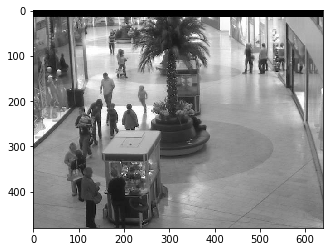

In [131]:
def read_image(number, display=False):
    path = './frames/frames/seq_{}.jpg'.format(str(number).zfill(6))
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if display:
        plt.imshow(img, cmap='gray')
    return img
        
read_image(22, display=True)

In [132]:
frames = []
for i in range(1, 2001):
    frames.append(read_image(i))

In [133]:
print(len(frames))

2000


## Reading people boxes (positives) from frames and analysis on distribution

In [134]:
people_boxes = genfromtxt('./people_rectangles.csv', dtype=int, delimiter=',', skip_header=1)

In [135]:
list_people_boxes = []
for b in people_boxes:
    idx, x, y, w, h = b
    img = frames[idx-1]
    cropped_img = img[y:y+h,x:x+w]
    list_people_boxes.append(cropped_img)

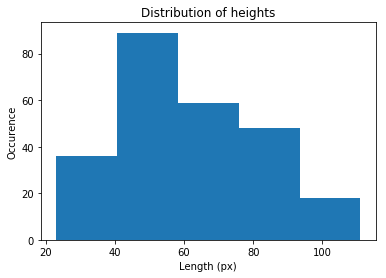

61.5


In [136]:
height = [list_people_boxes[i].shape[0] for i in range(0, 250)]
plt.hist(height, bins=5) 
plt.title("Distribution of heights")
plt.xlabel("Length (px)")
plt.ylabel("Occurence")
plt.show()
print(mean(height))

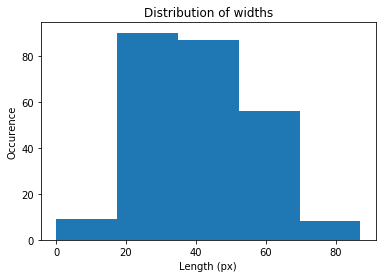

40.724


In [137]:
width = [list_people_boxes[i].shape[1] for i in range(0, 250)]
plt.hist(width, bins=5) 
plt.title("Distribution of widths")
plt.xlabel("Length (px)")
plt.ylabel("Occurence")
plt.show()
print(mean(width))

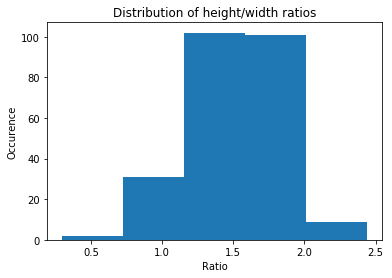

1.5239100335


In [138]:
# Shape distribution
# Maping 100 height to width ratio
ratios = [(float) (list_people_boxes[i].shape[0])/(list_people_boxes[i].shape[1]) for i in range(0, 250) if (list_people_boxes[i].shape[1]) != 0]
plt.hist(ratios, bins=5) 
plt.title("Distribution of height/width ratios")
plt.xlabel("Ratio")
plt.ylabel("Occurence")
plt.show()
print(mean(ratios))

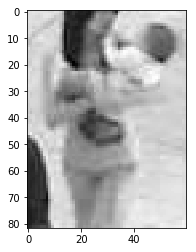

In [139]:
plt.imshow(list_people_boxes[3], cmap='gray')

## Resize people boxes

In [140]:
resized_imgs = []
dim = (40, 60)
resized_img = cv2.resize(list_people_boxes[1], dim, interpolation = cv2.INTER_AREA)
for l in list_people_boxes:
    if l.any():
        resized_img = cv2.resize(l, dim, interpolation = cv2.INTER_AREA)
        resized_imgs.append(resized_img)

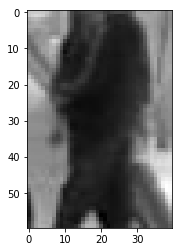

In [141]:
plt.imshow(resized_imgs[50], cmap='gray')

## Creating non-people (negative) boxes from frames

In [142]:
def create_negatives():
    negatives=[]
    for n in range(0, 2000):
        for y in range(0, frames[n].shape[0]-20,60):
            for x in range(0, frames[n].shape[1]-20,40):
                for box in people_boxes:
                    if(box[0] < n):
                        continue
                    if((box[0] == n) and (x >= box[1] - 39) and (x <= box[1] + box[3]) and (y >= box[2] - 59) and (y <= box[2] + box[4])):
                        break
                    elif (box[0] == n+1):
                        negatives.append([n+1,x,y,40,60])
                        break;
                    if(n > 0 and n % 100 == 0):
                        print(str(n) + 'th frame')

    with open('negative_rectangles.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['image_id', 'x', 'y', 'w', 'h'])
        writer.writerows(negatives)

In [143]:
create_negatives()

KeyboardInterrupt: 

In [144]:
non_people_boxes = genfromtxt('./negative_rectangles.csv', dtype=int, delimiter=',', skip_header=1)

In [145]:
negative_boxes = []
for b in non_people_boxes:
    idx, x, y, w, h = b
    img = frames[idx-1]
    cropped_img = img[y:y+h,x:x+w]
    negative_boxes.append(cropped_img)
len(negative_boxes)

163828

## Generating training set and test set

In [146]:
negative_boxes = negative_boxes[-30000:]

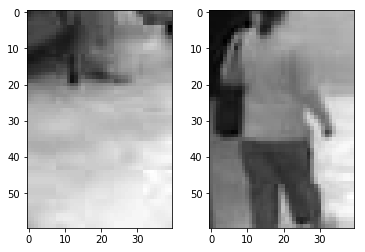

In [147]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(negative_boxes[503], cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(resized_imgs[0], cmap='gray')
plt.show()

In [148]:
negative = np.asarray(negative_boxes)
positive = np.asarray(resized_imgs)
print(negative.shape)
print(positive.shape)

(30000, 60, 40)
(31163, 60, 40)


In [149]:
# Removing NaNs although there shouldn't be any
negative = np.nan_to_num(negative)
positive = np.nan_to_num(positive)
print(negative.shape)
print(positive.shape)

(30000, 60, 40)
(31163, 60, 40)


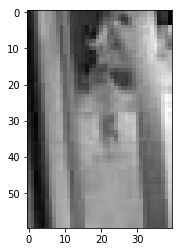

In [150]:
plt.imshow(negative[3349], cmap='gray')

In [151]:
# Generating labels
negative_labels = np.full((negative.shape[0],), 0)
positive_labels = np.full((positive.shape[0],), 1)

In [152]:
data = np.vstack((negative, positive))
labels = np.concatenate((negative_labels, positive_labels), axis=None)

In [153]:
print(data.shape)
print(labels.shape)

(61163, 60, 40)
(61163,)


In [154]:
from sklearn.model_selection import train_test_split

# Split test and training set
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.17, test_size=0.02)

In [155]:
X_train.shape

(10397, 60, 40)

## Features preprocessing (HoG features)

In [156]:
hog_image, h = feature.hog(resized_imgs[67], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualise=True)

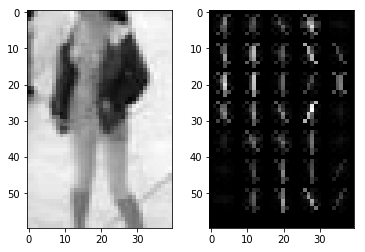

In [157]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(resized_imgs[67], cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(h, cmap='gray')
plt.show()

In [158]:
from skimage import feature

def preprocess(X_train):
    h_train = [feature.hog(img, 
                           orientations=9, 
                           pixels_per_cell=(8, 8), 
                           cells_per_block=(2, 2)) 
               for img in X_train]
    return np.asarray(h_train)
    
preprocessed_train = preprocess(X_train)

In [159]:
preprocessed_train.shape

(10397, 864)

## Generate SVM classifier, and measure accuracy

In [160]:
clf = svm.SVC(C=100)
clf.fit(preprocessed_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [161]:
import pickle
s = pickle.dumps(clf)

In [162]:
p_test = preprocess(X_test)

In [163]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(p_test)
accuracy_score(y_test, y_pred)

0.9738562091503268

## Sliding window approach to count number of detection in a frame

In [234]:
def predict_nb_detections(frame, clf):
    boxes, confidences = [], []
    h, w = frame.shape
    classes = clf.classes_
    score_thresh = 1.0
    iou_thresh = 0.1
    x, y = 0, 0
    while x <= (w-40):
        y=0
        while y <= (h-60):
            box = frame[y:y+60, x:x+40]
            hog = feature.hog(box, 
                           orientations=9, 
                           pixels_per_cell=(8, 8), 
                           cells_per_block=(2, 2))
            confidence_score = clf.decision_function([hog])
            # It's a person! (in other words, it's classes[1] == 1)
            if confidence_score[0] > 0:
                boxes.append([x, y, 40, 60])
                confidences.append(abs(confidence_score[0]))
            y += 20
        x+= 10
                
    # Non-max suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, score_thresh, iou_thresh)
    return len(idxs)

## Count number detections for 2000 frames

In [236]:
preds = []
for i in range(1, 2001):
    pred = predict_nb_detections(frames[i-1], clf)
    preds.append([i, pred])
    if (i % 100 == 0): print(str(i)+'th frame')

    
with open('final_results.csv', 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'count'])
    writer.writerows(preds)

100th frame
200th frame
300th frame
400th frame
500th frame
600th frame
700th frame
800th frame
900th frame
1000th frame
1100th frame
1200th frame
1300th frame
1400th frame
1500th frame
1600th frame
1700th frame
1800th frame
1900th frame
2000th frame


## Calculate accuracy using YOLO results as ground truth

In [87]:
yolo_results = genfromtxt('./yolov3_results.csv', dtype=int, delimiter=',', skip_header=1)
results = genfromtxt('./final_results.csv', dtype=int, delimiter=',', skip_header=1)

In [91]:
# remove ID
yolo_results = yolo_results[:,1:]
results = results[:,1:]

In [94]:
print(str(accuracy_score(yolo_results, results)*100)+"%")

6.550000000000001%


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [129, 129, 129, ..., 170, 173, 173],
       [128, 128, 128, ..., 160, 164, 167],
       [131, 131, 130, ..., 146, 147, 147]], dtype=uint8)

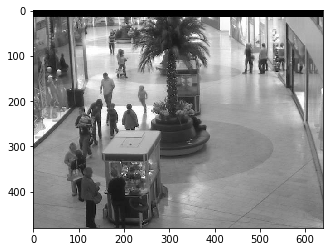

In [238]:
def read_image_colour(number, display=False):
    path = './frames/frames/seq_{}.jpg'.format(str(number).zfill(6))
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if display:
        plt.imshow(img, cmap='gray')
    return img
        
read_image(22, display=True)

In [241]:
def print_rectangles(nb, clf):
    frame_colour = read_image_colour(nb)
    frame = read_image(nb)
    boxes, confidences = [], []
    h, w = frame.shape
    print(frame.shape)
    classes = clf.classes_
    score_thresh = 1.0
    iou_thresh = 0.1
    x, y = 0, 0
    while x <= (w-40):
        y = 0
        while y <= (h-60):
            box = frame[y:y+60, x:x+40]
            hog = feature.hog(box, 
                           orientations=9, 
                           pixels_per_cell=(8, 8), 
                           cells_per_block=(2, 2))
            confidence_score = clf.decision_function([hog])
            # It's a person! (in other words, it's classes[1] == 1)
            if confidence_score[0] > 0:
                boxes.append([x, y, 40, 60])
                confidences.append(abs(confidence_score[0]))
            y += 20
        x+= 10
        
    # Non-max suppression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, score_thresh, iou_thresh)
    
    # Ensure at least one detection exists
    if len(idxs) > 0:
        # Iterate over corrected detected persons
        for idx in idxs.flatten():
            # Draw detection box
            x, y = boxes[idx][0], boxes[idx][1]
            w, h = boxes[idx][2], boxes[idx][3]
            cv2.rectangle(frame_colour, (x, y), (x + w, y + h), color=(255,0,0), thickness=1)
    
    final_img = frame_colour.copy()
    
    big = cv2.resize(final_img, dsize=(0,0), fx=5, fy=5)
    # Output resulting image
    plt.figure(figsize=(15,15))
    plt.imshow(big)

(480, 640)


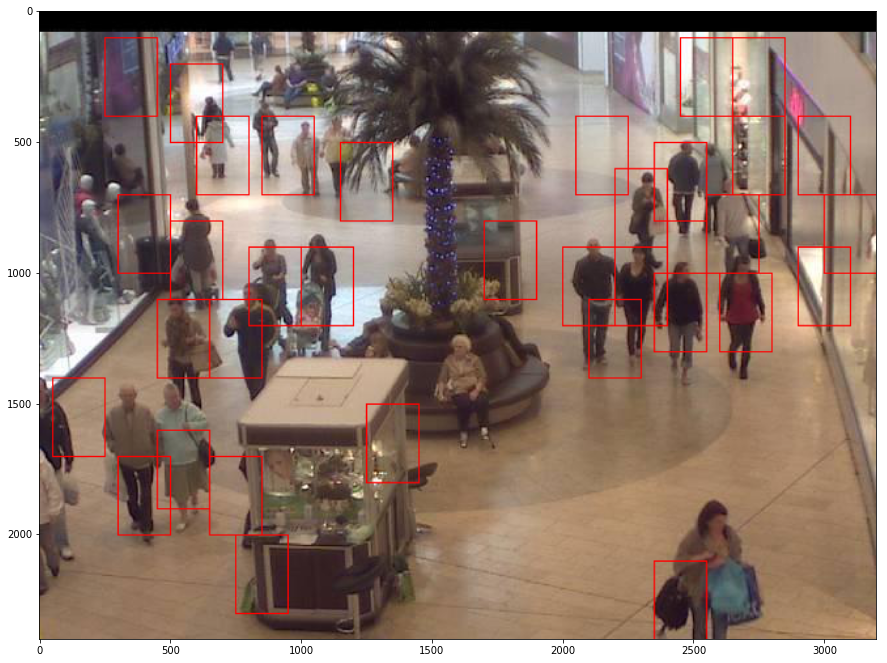

In [242]:
print_rectangles(250, clf)